In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
from matplotlib.colors import LinearSegmentedColormap
from sklearn.datasets import make_moons
# PyTorch
import torch

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import likelihoods
import priors
import utils

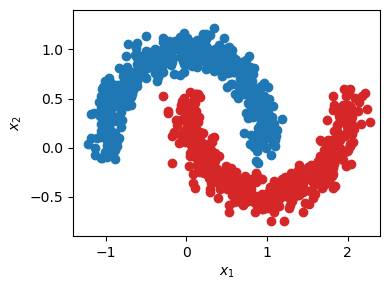

In [3]:
N = 1_000
X_numpy, y_numpy = make_moons(n_samples=N, noise=0.1, random_state=42)

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

X_train, X_val = X[:int((4/5)*N)], X[int((4/5)*N):]
y_train, y_val = y[:int((4/5)*N)], y[int((4/5)*N):]

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color="#1F77B4")
ax.scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color="#D62728")
ax.set_xlim([-1.4, 2.4])
ax.set_ylim([-0.9, 1.4])
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

fig.tight_layout()
plt.show()

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train.view(-1).long())
val_dataset = torch.utils.data.TensorDataset(X_val, y_val.view(-1).long())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))


In [5]:
def train_one_epoch(model, criterion, optimizer, dataloader):
    
    running_loss = 0.0
    for X_batch, y_batch in dataloader:
        
        batch_size = len(X_batch)
        
        optimizer.zero_grad()
        params = utils.flatten_params(model)
        logits = model(X_batch)
        loss = criterion(logits, y_batch, params, len(dataloader.dataset))
        running_loss += (1 / batch_size) * loss.item()
        loss.backward()
        optimizer.step()
        
    return running_loss
        
def evaluate(model, criterion, dataloader):
    
    with torch.no_grad():
        
        running_loss = 0.0
        for X_batch, y_batch in dataloader:

            batch_size = len(X_batch)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            running_loss += (1 / batch_size) * loss.item()
            
    return running_loss


In [6]:
class MAPLoss(torch.nn.Module):
    def __init__(self, likelihood, prior):
        super().__init__()
        self.likelihood = likelihood
        self.prior = prior

    def forward(self, logits, labels, params, n):
        nll = self.likelihood(logits, labels, reduction="mean")
        log_prior = self.prior.log_prob(params)
        loss = nll - (1 / n) * log_prior
        return loss

model = layers.RandomFourierFeaturesGaussianProcess(in_features=2, out_features=2, learnable_lengthscale=False, lengthscale=0.3, learnable_outputscale=False, outputscale=0.8)
likelihood = likelihoods.CategoricalLikelihood()
prior = priors.GaussianPrior()

criterion = MAPLoss(likelihood, prior)

state_dict = {
    "model": model.state_dict(),
    "likelihood": likelihood.state_dict(),
    "prior": prior.state_dict(),
}

best_val_loss = float("inf")
best_state_dict = None

for lr in [0.1, 0.01, 0.001, 0.0001]:

    model.load_state_dict(state_dict["model"])
    likelihood.load_state_dict(state_dict["likelihood"])
    prior.load_state_dict(state_dict["prior"])
    
    optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=lr, weight_decay=0.0)
    
    epochs = 10_000
    
    for epoch in tqdm.tqdm(range(epochs)):
        
        train_loss = train_one_epoch(model, criterion, optimizer, train_dataloader)
        val_loss = evaluate(model, torch.nn.CrossEntropyLoss(), val_dataloader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = {
                "model": model.state_dict(),
                "likelihood": likelihood.state_dict(),
                "prior": prior.state_dict(),
            }
        
model.load_state_dict(best_state_dict["model"])
likelihood.load_state_dict(best_state_dict["likelihood"])
prior.load_state_dict(best_state_dict["prior"])


100%|██████████| 10000/10000 [01:54<00:00, 87.52it/s]


<All keys matched successfully>

In [7]:
with torch.no_grad():
    model.update_covariance_from_dataloader(train_dataloader)

    xx, yy = np.meshgrid(np.arange(-6, 6, 0.1), np.arange(-6, 6, 0.1))
    linspace = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    probs = model.predict_proba(linspace, num_samples=10_000)[:,1].reshape(xx.shape)
    

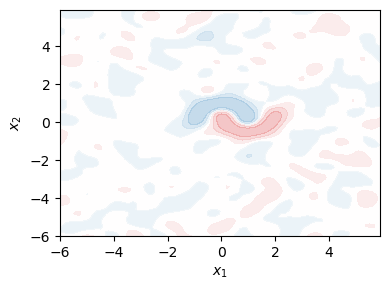

In [9]:
colors = ["#1F77B4", "#5799C7", "#8FBBDA", "#C7DDED", "#FFFFFF", "#F5C9CA", "#EB9394", "#E15D5E", "#D62728"]
cmap = LinearSegmentedColormap.from_list('bwr', colors)

xx, yy = np.meshgrid(np.arange(-6, 6, 0.1), np.arange(-6, 6, 0.1))

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

#ax.scatter(X[:,0][y_numpy==0], X[:,1][y_numpy==0], color="#1F77B4")
#ax.scatter(X[:,0][y_numpy==1], X[:,1][y_numpy==1], color="#D62728")
ax.contourf(xx, yy, probs, alpha=0.3, cmap=cmap)
#ax.set_xlim([-1.4, 2.4])
#ax.set_ylim([-0.9, 1.4])
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

fig.tight_layout()

plt.show()
    